<h1 align="center" style="background-color:#616161;color:white">Outlier Analysis & Cleanup</h1>

<h3>Summary</h3>

<font color=blue>
Two types of analysis was conducted
* Daily LIstening Habits: Analysis of the number of unique tracks vs. num. of plays a user seen on a daily basis
* Histogram of the time period in between song plays
</font>    

<h3 style="background-color:#616161;color:white">0. Code setup</h3>

In [63]:
import os
import sys
import pandas as pd
import numpy as np
import datetime
import csv
import json
import sqlite3
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from pathlib import Path
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
## Parameters you can change

# Abs path to settings file
root = "C:/DS/Github/MusicRecommendation"  # BA, Windows
i = datetime.datetime.now()
outputPath = root + "/4_preliminaryanalysis/outputs/%s_%s_%s/" % (i.day, i.month, i.year) 

## Finish setting up
os.chdir(root)
## Add the prelim module
fPath = root + "/1_codebase"
if fPath not in sys.path: sys.path.append(fPath)
from codebase import *

settingsDict =  loadSettings()

# Load data from database
dbPath = root + settingsDict['dbPath']

#--------------------- Functions ----------------------------------#
def getRandomUsers(maxUsers):
    db = sqlite3.connect(dbPath)
    SQStr ="SELECT userID FROM tblUser ORDER BY RANDOM() LIMIT " + maxUsers

def exportToCSV(cursor, fPath):
    
    # Check output folder exists
    _ensurePathExists(fPath)
    
    with open(fPath, "w", newline='') as csv_file:  # Python 3 version    
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow([i[0] for i in cursor.description]) # write headers
        csv_writer.writerows(cursor)


def _ensurePathExists(fPath):
    path = Path(fPath)
    path.parent.mkdir(parents=True, exist_ok=True) 

<h3 style="background-color:#616161;color:white">1. Generate CSV exports for analysis in visualization software</h3>

In [32]:
con = sqlite3.connect(dbPath)
cur = con.cursor()

sqlStr ='SELECT Cast(substr(userID,-5) as integer) as user,date(PlayedTimestamp) as PlayedTimeStamp ,count(*) as NumOfPlays, count(Distinct trackID) as NumOfTracks from tblInputData group by userID, date(PlayedTimestamp) ORDER BY NumOfPlays;'

# Export to CSV
cur.execute(sqlStr)
exportToCSV(cur,outputPath + 'dataset1.csv')

con.close()

<h3 style="background-color:#616161;color:white">2. Basic analysis</h3>

In [3]:
con = sqlite3.connect(dbPath)
sqlStr ='SELECT Cast(substr(userID,-5) as integer) as user,date(PlayedTimestamp) as PlayedTimeStamp ,count(*) as NumOfPlays, count(Distinct trackID) as NumOfTracks from tblInputData group by userID, date(PlayedTimestamp) ORDER BY NumOfPlays;'

# Load into Pandas
res = pd.read_sql_query(sqlStr, con)
con.close()

# Change data types
res['user'] = res['user'].astype('str')
res['PlayedTimeStamp'] =  pd.to_datetime(res['PlayedTimeStamp'])
#res.dtypes

In [4]:
res['PlayedTimeStamp'].describe()

count                  391475
unique                   1589
top       2009-04-27 00:00:00
freq                      439
first     2005-02-14 00:00:00
last      2013-09-29 00:00:00
Name: PlayedTimeStamp, dtype: object

<font color=blue>
The date range is from 27th April 2009 to 29th Sept 2013 
</font>

In [125]:
res['user'].describe()

count     391475
unique       992
top          833
freq        1457
Name: user, dtype: object

<font color=blue>
There are 992 unique users. 
</font>

In [141]:
res.describe(percentiles = [.5, .95, .99])

,NumOfPlays,NumOfTracks
count,391475.000000,391475.000000
mean,48.919773,35.828385
std,57.588075,42.043862
min,1.000000,0.000000
50%,31.000000,23.000000
95%,153.000000,112.000000
99%,295.000000,205.000000
max,2862.000000,1520.000000



* <font color=blue>The average number of daily plays was 48, and the average number of unique daily tracks was 35</font>
*  <font color=blue>The higest number of daily plays was a very large <b>2862</b></font>
*  <font color=blue>The 99th percentile was only 295, so perhaps this makes a good cut-off point</font>

In [145]:
qNumOfPlays = 295

res[(res['NumOfPlays'] > qNumOfPlays)].user.nunique()

# If you wish to drill down further use this:
#res[(res['NumOfPlays'] > qNumOfPlays)].groupby(['user']).count()

253

* <font color=blue>We would be excluding 253 users if we did this - which is a large portion of our 992 unique users.</font>

In [155]:
res.groupby(['user']).mean().describe([.5, .95, .99])

,NumOfPlays,NumOfTracks
count,992.000000,992.000000
mean,45.911395,33.153739
std,36.674290,25.153083
min,1.000000,0.666667
50%,35.920913,27.071905
95%,108.196133,78.911361
99%,208.585319,142.503486
max,337.670588,243.470703


* <font color=blue>When we take the average tracks played on a daily basis by user we get a 99th percentile of 208 with the max average being 337.</font>
* <font color=blue>The question at this stage is whether we exclude any days where the number of tracks played by a user exceeded a certain threshold (say 295).</font>
* <font color=blue>Our analysis suggests that a large portion of users (253 our of 992) did have such excessive plays therefore exlcuding this many users is not an option</font>
* <font color=blue>If we average out across thee days then we find the data looks more normal - the max average was 337 tracks, still large but within the bounds of reality.</font>
* <font color=blue>Of course why there are some days with excessively high track plays is a mystery. Further analysis did not show any obvious patterns other than user 8 who appeared to be particularly excessive number of plays. </font>

In [200]:
tmp=res[(res['NumOfPlays'] > 800)].groupby(['user']).count()
tmp

,PlayedTimeStamp,NumOfPlays,NumOfTracks
user,,,
155,1,1,1
199,2,2,2
262,1,1,1
554,1,1,1
666,1,1,1
791,2,2,2
8,17,17,17


In [217]:
#res[(res['user'] =='8') & (res['NumOfPlays'] > 500)]
res[(res['user'] =='8')].mean()

NumOfPlays     315.550847
NumOfTracks     20.084746
dtype: float64

<font color=blue>
This analysis plus additional ones done that show user 8 playing songs in very rapid succession for an entire day indicate it may not be a real user and therefore ought to be removed.

It is unclear if this is the case for other excessive users however it was decided they would be kept in the analysis.
</font>

<h3 style="background-color:#616161;color:white">3. Interval time</h3>

In [8]:
#con = sqlite3.connect(dbPath)
#sqlStr ='Select userID, MinsSincePrevPlay, PlayedTimestamp, historyID from tblMain order by userID, historyID'
#res = pd.read_sql_query(sqlStr, con)
#con.close()

# Change data types
res['UserID'] = res['UserID'].astype('str')
res['PlayedTimestamp'] =  pd.to_datetime(res['PlayedTimestamp'])

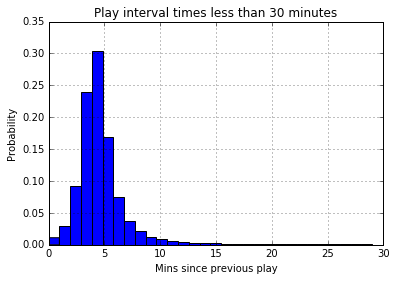

<10min    17467343
30 min      579430
1hr         164426
2hrs        138871
4hrs        114257
8 hrs       100019
16hrs       163356
1day        113834
2days        58733
3days        20670
4days         9543
5days         5613
6days         3524
7days+        2393
Name: categories, dtype: int64

In [115]:
# Chart 1
a=res[(res['MinsSincePrevPlay'] < 30)]
b=res[(res['MinsSincePrevPlay'] > 30)]

# the histogram of the data
n, bins, patches = plt.hist(a['MinsSincePrevPlay'], 30,normed=1)
_ = plt.xlabel('Mins since previous play')
_ = plt.ylabel('Probability')
_ = plt.title('Play interval times less than 30 minutes')
plt.grid(True)

plt.show()

bins = [0,10,30, 60, 120, 240, 480, 960, 1440,2880,4320, 5760, 7200, 8640, 10080]
group_names = ['<10min','30 min', '1hr', '2hrs', '4hrs', '8 hrs','16hrs','1day','2days','3days','4days','5days','6days','7days+']
categories = pd.cut(res['MinsSincePrevPlay'], bins,labels=group_names)
res['categories'] = pd.cut(res['MinsSincePrevPlay'], bins,labels=group_names)
res['dayOfWeek'] = res['PlayedTimestamp'].dt.dayofweek

pd.value_counts(res['categories'],sort=False)

* <font color=blue>As one would expect, the average interval between plays of 4 minutes corresponds to an average length of a song, indicating consequtive listens. It tails off significantly after that.</font>
* <font color=blue>Beyond the hour mark we see that 16 hours appears to be unusually popular. Let's see if it's associated with any day of the week</font>

In [113]:
pd.crosstab(res['categories'],res['dayOfWeek'],normalize ='index') # 0 = monday

dayOfWeek,0,1,2,3,4,5,6
categories,,,,,,,
<10min,0.15,0.15,0.15,0.14,0.14,0.13,0.14
30 min,0.15,0.15,0.15,0.15,0.14,0.13,0.14
1hr,0.15,0.15,0.15,0.15,0.14,0.13,0.14
2hrs,0.15,0.15,0.15,0.15,0.14,0.13,0.13
4hrs,0.15,0.15,0.15,0.15,0.14,0.13,0.14
8 hrs,0.15,0.15,0.15,0.15,0.14,0.13,0.14
16hrs,0.14,0.15,0.15,0.15,0.14,0.14,0.13
1day,0.13,0.16,0.16,0.16,0.15,0.12,0.12
2days,0.15,0.13,0.14,0.14,0.14,0.15,0.16


* There does not appear to be any patterns here

<h3 style="background-color:#616161;color:white">4. Conclusion</h3>

Section 2:
* <font color=blue>User 8 appears not to be a valid user and therefore will be removed. </font>
* <font color=blue>It is unclear if this is the case for other excessive users however it was decided they would be kept in the analysis. </font>

Section 3:
* <font color=blue>The vast majority of users listen to songs consequtively as one would expect</font>
* <font color=blue>Beyond that the drop-off rate is steep, and particularly drops after the 1 day period</font>
* <font color=blue>From a modeling point of view we will classify the data into 3 buckets:</font> 
    * <font color=blue>'single session' : 10 minutes or under</font>
    * <font color=blue>'same day': 24 hours or under</font>
    * <font color=blue>'long gap': more than 24 hours</font>
* <font color=blue>We will evaluate whether it's better tol have 1 model for all three of these categories or whether two or three models perform better</font>

<h3 style="background-color:#616161;color:white">END</h3>